# Stock Prediction Using Data From Yahoo Finance

### Table of contents 
1. Acknowledgments
2. Imports
2. EDA
3. Feature Engineering
1. Base line: prices are the same as the year before.
2. Linear model
3. Polynomial models
3. KNN
4. CNN
4. LSTM

#### Acknowledgements:
- https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7
- https://towardsdatascience.com/keep-it-simple-keep-it-linear-a-linear-regression-model-for-time-series-5dbc83d89fc3

#### Import and Function defenitions

In [1]:
from pandas_datareader import data as web
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from datetime import date
import yfinance as yf
import seaborn as sns
from math import sqrt
import pandas as pd
import numpy as np
import IPython
import IPython.display

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import prophet
import tensorflow as tf
from fbprophet import Prophet

import math
import datetime

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

sns.set_style('whitegrid')
yf.pdr_override()

In [2]:
def get_data(ticker):
    """
    INPUT: ticker - (str) ticker of a stock to be predicted
    
    OUTPUT: data - (pandas dataframe) dataframe with stock price info. 
            Includes following columns: 
                - Open
                - High
                - Low
                - Close
                - Adj Close
                - Volume
    """
    
    today = date.today()
    
    data = web.get_data_yahoo(ticker, end = today)
    
    return data

In [3]:
def line_plot(df, col_name, title):
    """
    INPUT: df - (pandas dataframe) dataframe that contains data to be ploted
           col_name - (string) column to be ploted
           ticker - (string) company stock ticker 

    OUTPUT: N/A
    """
    plt.figure(figsize=(14, 8))
    df[col_name].plot()
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(title)
    plt.show()

In [4]:
def compute_errors(y_test, predictions):
    """
    INPUT: y_test - (list) prediction values
           predictions - (list) prediction values

    OUTPUT: print MSE, RMSE, MAPE
    """
    # Compute errors
    mse_base = mean_squared_error(y_test, predictions)
    rmse_base = np.sqrt(mse_base)
    mape = mean_absolute_percentage_error(y_test, predictions)

    print('Mean squared error of a model is ', mse_base)
    print('Root mean squared error of a model is ', rmse_base)
    print('Mean absolute percentage error of a model is ', mape)


## Get the Data

At this step I will get user input for the ticker and load coresponding stock prices data from Yahoo Finance.

In [5]:
ticker = input()

AMZN


In [6]:
# load the data
try:
    df = get_data(ticker)
except Exception:
    print('Data can not be loaded. Please check your ticker and try again')

[*********************100%***********************]  1 of 1 completed


In [7]:
# subset the dataset
df = df[df.index > '1999-12-31']

## Data Exploration

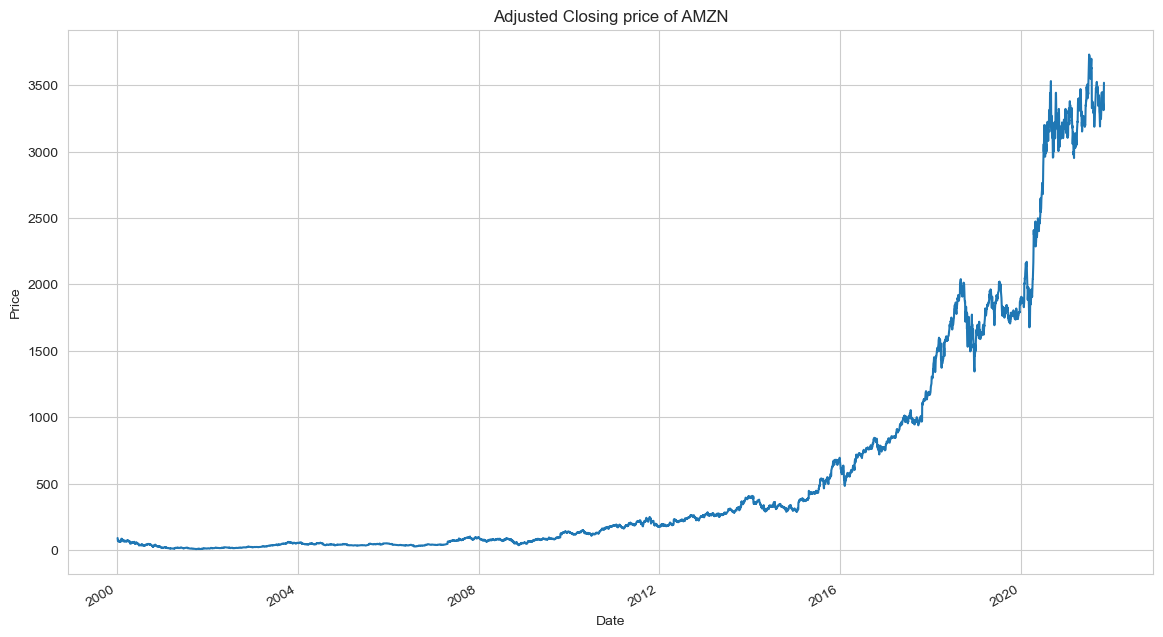

In [8]:
# plot closing price column (value we will try to predict)
line_plot(df, 'Adj Close', "Adjusted Closing price of {}".format(ticker))

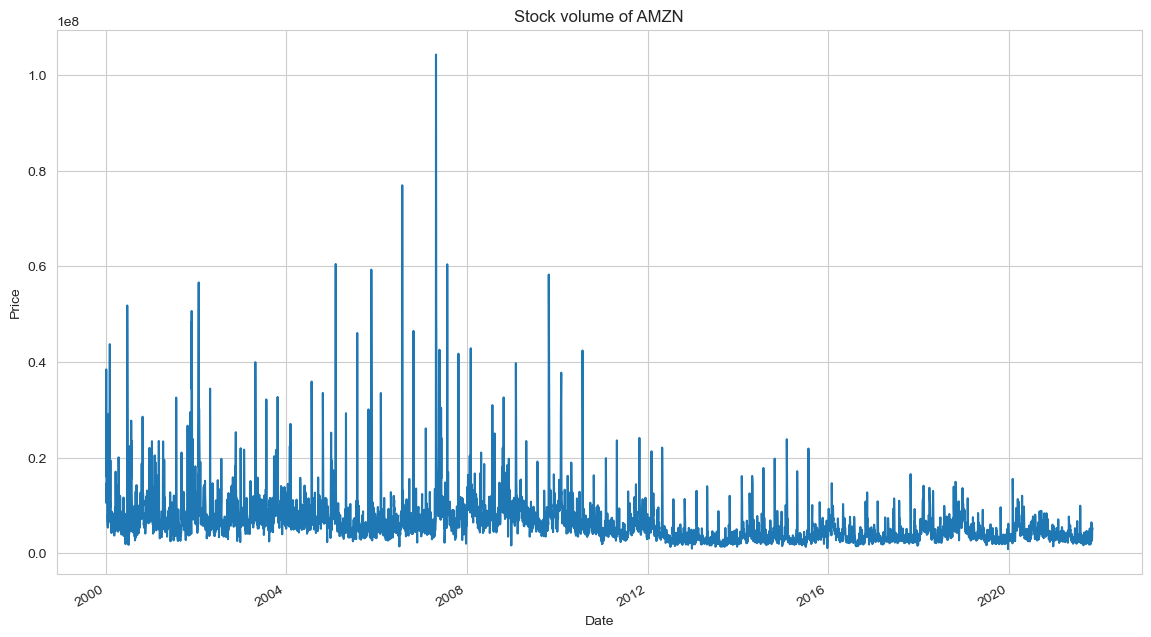

In [9]:
# plot stock volume
line_plot(df, 'Volume', 'Stock volume of {}'.format(ticker))

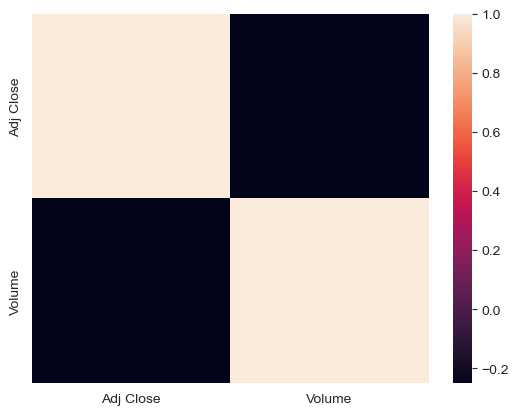

In [12]:
sns.heatmap(df[['Adj Close', 'Volume']].corr())
plt.show()

## Feature Engineering

Reference: https://alphascientist.com/feature_engineering.html

In [13]:
df.loc[:, 'ticker'] = ticker
df.loc[:, 'HL_PCT'] = ((df['High'] - df['Low']) / df['Adj Close'] * 100).values
df.loc[:, 'PCT_change'] = ((df['Adj Close'] - df['Open']) / df['Open'] * 100.0).values
df.loc[:, 'Daily_return'] = df['Adj Close'] / df['Open'] - 1

# Logarithmic transformation
df.loc[:, 'Volume'] = df['Volume'].apply(np.log)

# Differencing
df.loc[:, 'Change_1'] = df['Volume'].diff()
df.loc[:, 'Change_50'] = df['Volume'].diff(50)

# Moving Averages
# log of 5 day ma of volume
ma_5 = lambda x: x.rolling(5).mean()
df.loc[:, 'ma_5'] = df.groupby(by='ticker')['Volume'].apply(ma_5).apply(np.log)

# daily volume vs 200 day ma
ma_200 = lambda x: x.rolling(200).mean()
df.loc[:, 'ma_200'] = df['Volume'] / df.groupby(by='ticker')['Volume'].apply(ma_200) - 1

# daily closing price vs 50 day exponential ma
ema_50 = lambda x: x.ewm(span=50).mean()
df.loc[:, 'ema_50'] = df['Adj Close'] / df.groupby(by='ticker')['Adj Close'].apply(ema_50) - 1

# Z-Scores
zscore_fxn = lambda x: (x - x.rolling(window=200, min_periods=20).mean())/x.rolling(window=200, min_periods=20).std()
df.loc[:, 'z_score'] = df.groupby(by='ticker')['Adj Close'].apply(zscore_fxn)

# signing: volume increased or decreased? 
df.loc[:, 'volume_sign'] = df['PCT_change'].apply(np.sign)

# how many days in a raw a value has increased / decreased
plus_minus_fn = lambda x: x.rolling(20).sum()
df.loc[:, 'days_vol_increased'] = df.groupby(by='ticker')['volume_sign'].apply(plus_minus_fn)



/Users/my_love/opt/anaconda3/envs/predict-stocks/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/my_love/opt/anaconda3/envs/predict-stocks/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [14]:
# One-Hot Encoding for month
month_of_year = df.index.get_level_values(level='Date').month
one_hot_frame = pd.DataFrame(pd.get_dummies(month_of_year))
one_hot_frame.index = df.index

# create column names
columns = month = ["Jan", "Feb", "Mar", "Apr", 
                   "May", "Jun", "Jul","Aug", 
                   "Sep", "Oct", "Nov", "Dec"]

one_hot_frame.columns = columns
df = df.join(one_hot_frame)

# Weekday features
weekdays = pd.Series(df.index)
dummy = pd.get_dummies(weekdays.dt.dayofweek.values)
dummy.index = df.index

dummy.columns=['Mon', 'Tue', 'Wed', 'Thu', 'Fri']

df = df.join(dummy)

In [15]:
# drop columns that we know are not necessary
df_new = df.drop(columns=['Close', 'ticker'])
df_new.head()

,Open,High,Low,Adj Close,Volume,HL_PCT,PCT_change,Daily_return,Change_1,Change_50,...,Aug,Sep,Oct,Nov,Dec,Mon,Tue,Wed,Thu,Fri
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,81.5000,89.5625,79.046875,89.3750,16.595422,11.765734,9.662577,0.096626,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
2000-01-04,85.3750,91.5000,81.750000,81.9375,16.676991,11.899314,-4.026354,-0.040264,0.081569,NaN,...,0,0,0,0,0,0,1,0,0,0
2000-01-05,70.5000,75.1250,68.000000,69.7500,17.465062,10.215054,-1.063830,-0.010638,0.788071,NaN,...,0,0,0,0,0,0,0,1,0,0
2000-01-06,71.3125,72.6875,64.000000,65.5625,16.746811,13.250715,-8.063103,-0.080631,-0.718251,NaN,...,0,0,0,0,0,0,0,0,1,0
2000-01-07,67.0000,70.5000,66.187500,69.5625,16.167400,6.199461,3.824627,0.038246,-0.579411,NaN,...,0,0,0,0,0,0,0,0,0,1


Check Nan Values:

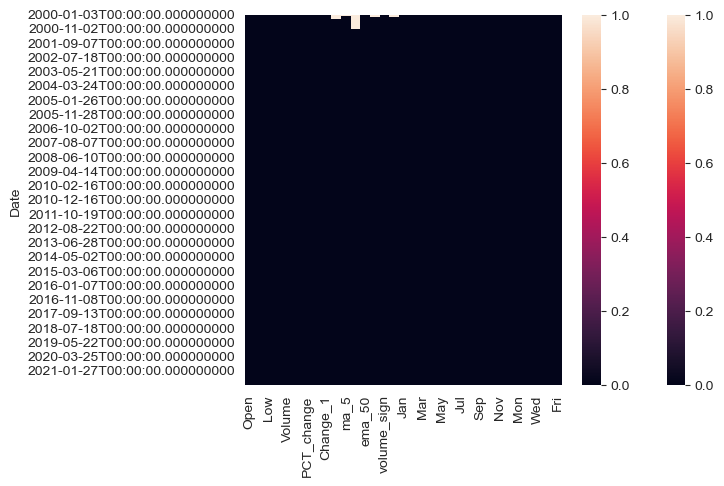

In [17]:
# visualize the existance of NA values
sns.heatmap(df_new.isna())
plt.show()

As we can see there are a couple of NA values. 

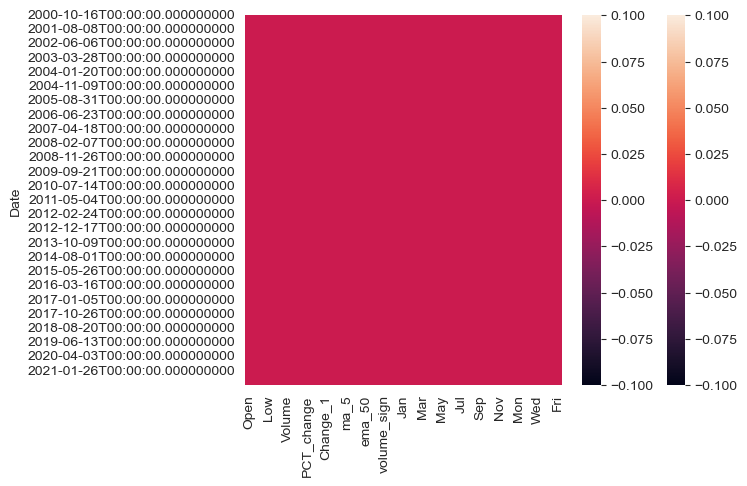

In [19]:
# drop NA values and visualize the result
df_new = df_new.dropna()
sns.heatmap(df_new.isna())
plt.show()

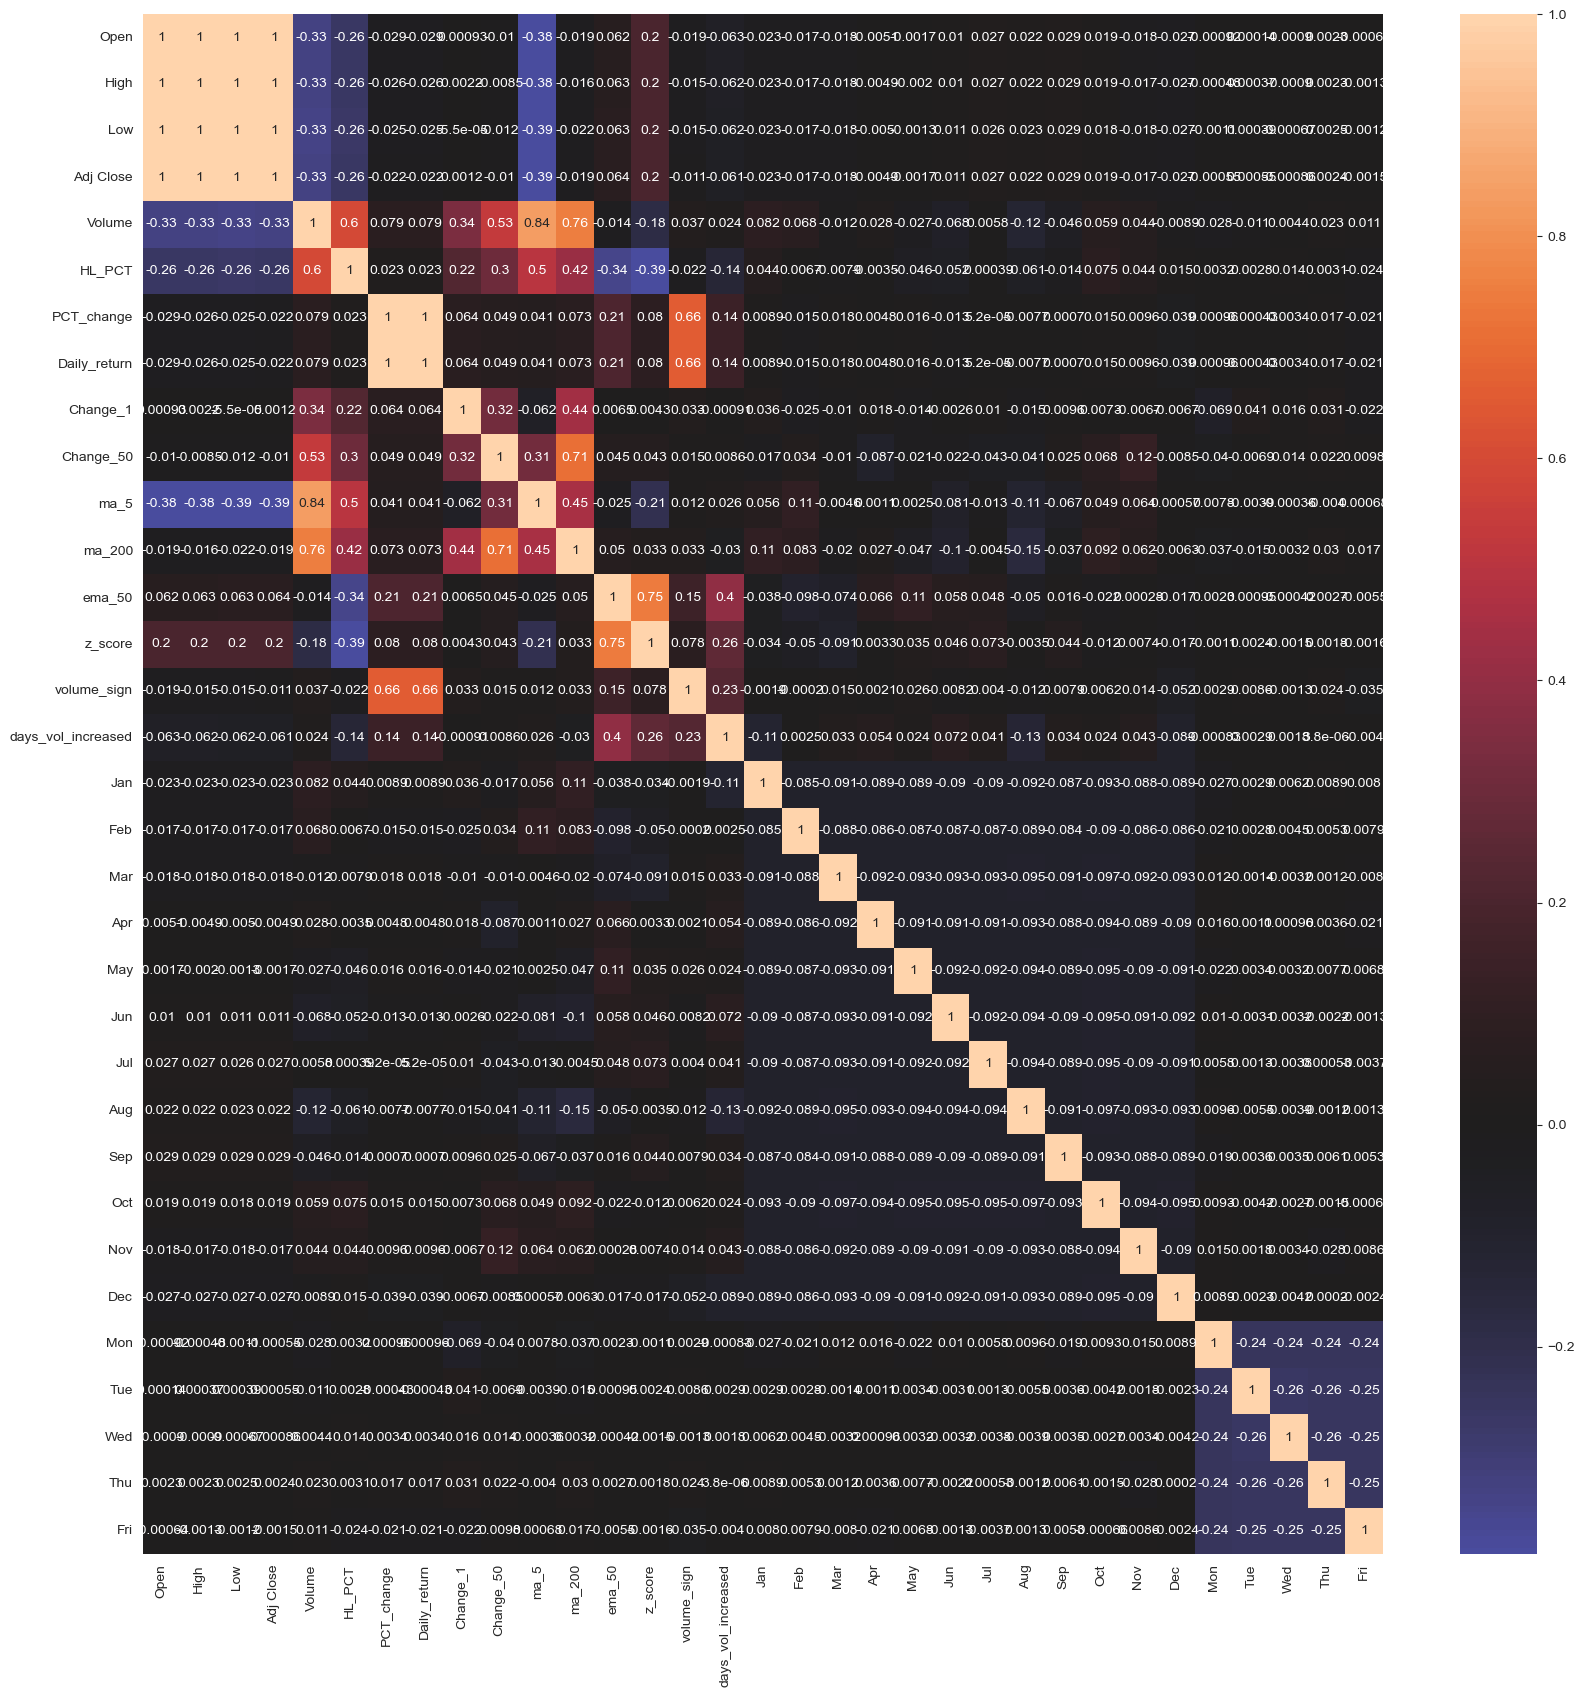

In [22]:
# Visualize the correlation of newly created features
plt.figure(figsize = (20,20))
sns.heatmap(df_new.corr(), annot=True, center=0)
plt.show()

As we can see there a couple of highly correlated features. To avoid unexpected behavior (ex: multicolinearity) we should drop some of them.

In [23]:
df_new = df_new.drop(columns=['Open', 'Low', 'High', 'z_score', 'Volume', 'Daily_return'])

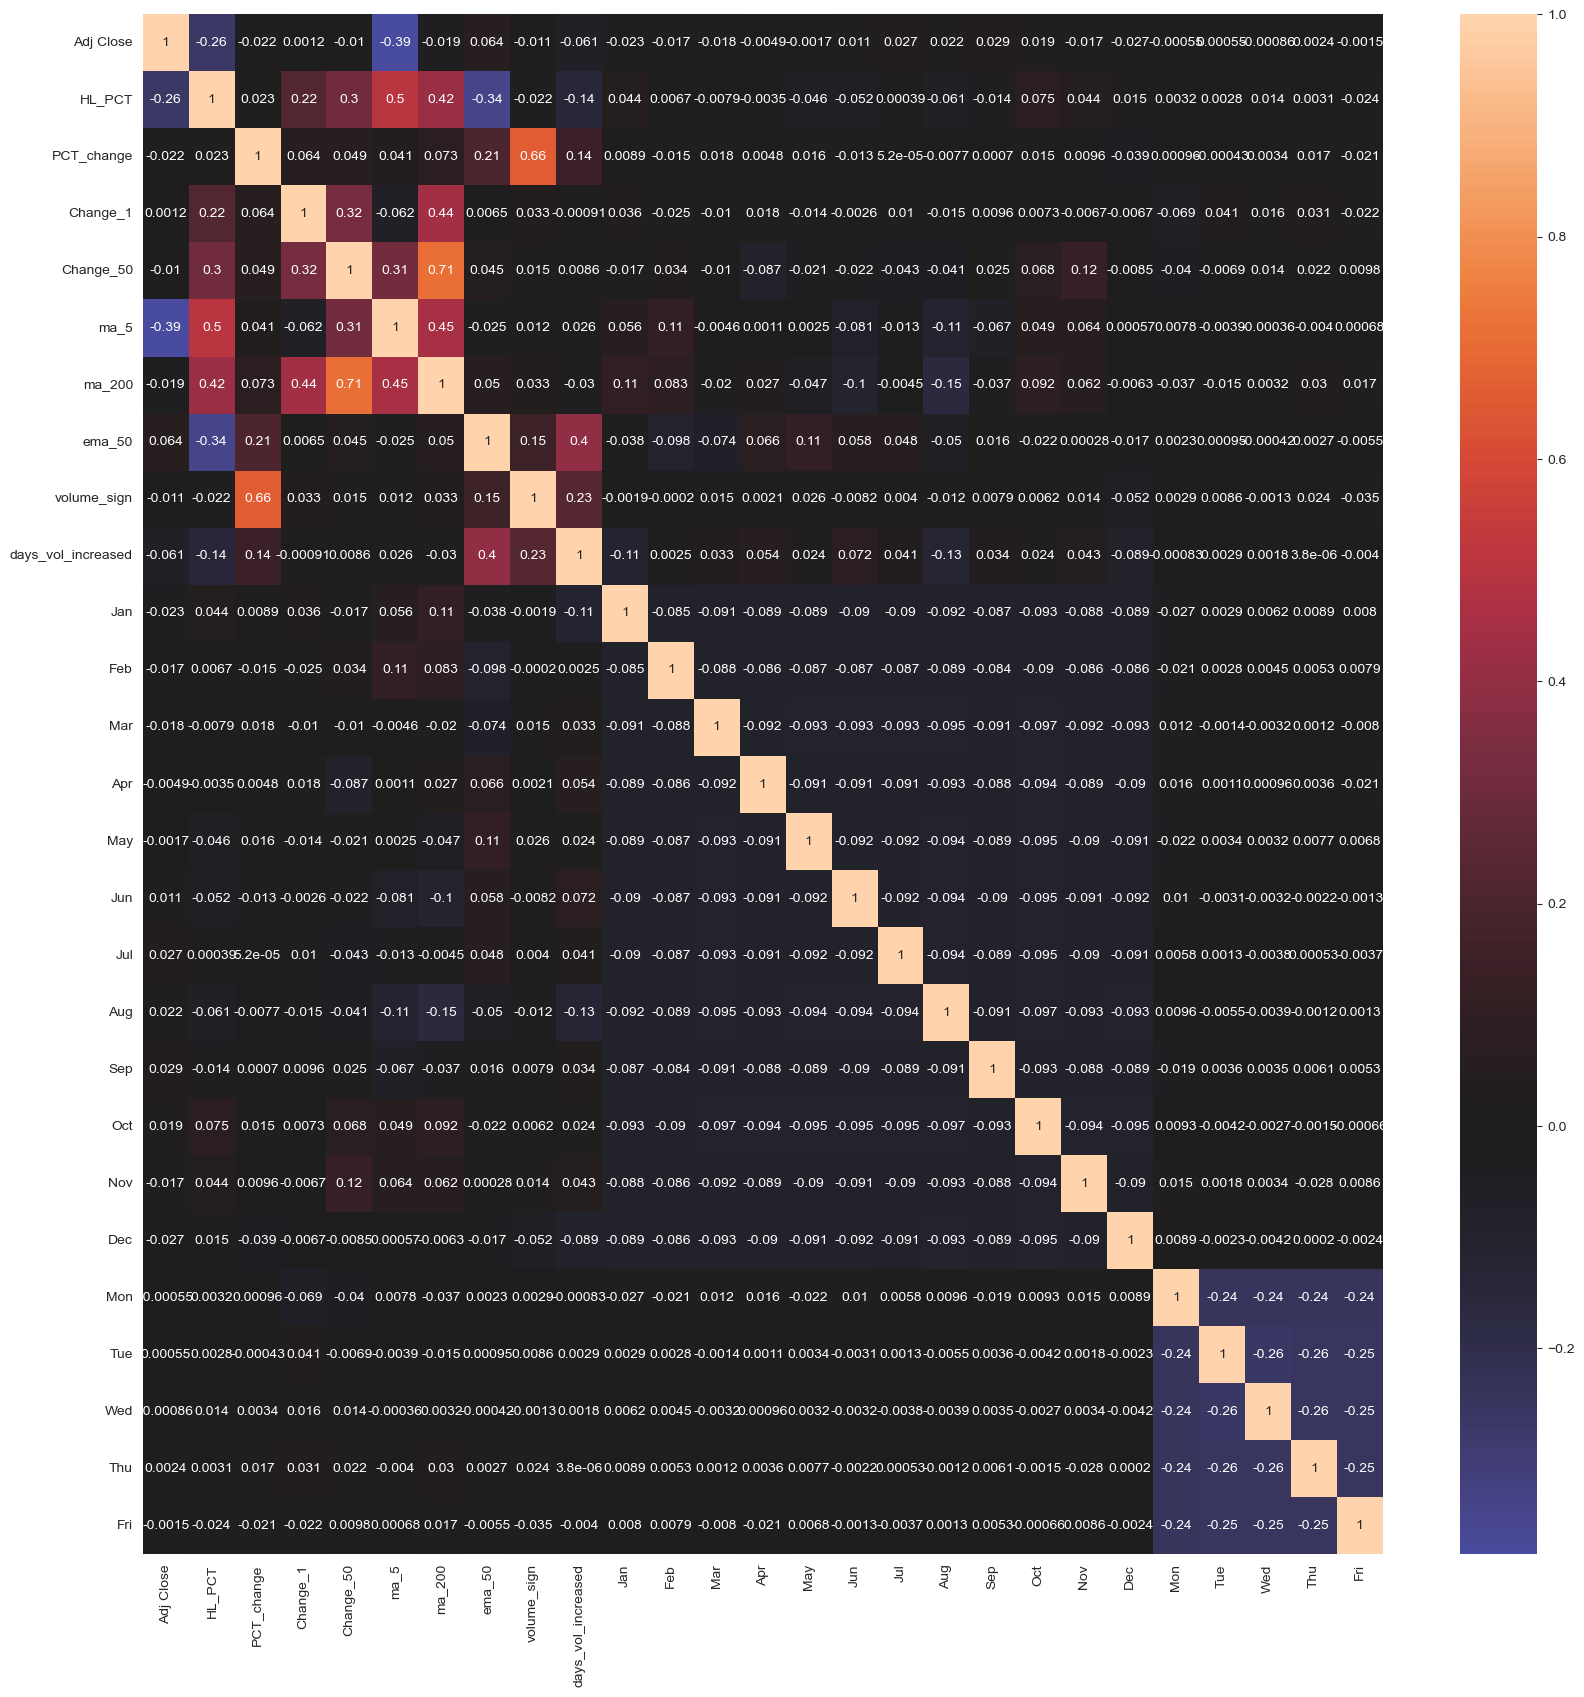

In [24]:
# Visualize feature correlations again
plt.figure(figsize = (20,20))
sns.heatmap(df_new.corr(), annot=True, center=0)
plt.show()

Now, as we have our features ready, we can start preparing the data for the forecasting model.

## Train test split

In [25]:
n = len(df_new)                              # total number of data smaples
num_features = df_new.shape[1]               # total number of features

df_train = df_new[0:int(n * 0.7)]            # set first 70% of data as training data
df_val = df_new[int(n * 0.7):int(n * 0.9)]   # next 20% as validation data
df_test = df_new[int(n * 0.9):]              # last 10% of data will be our test data

#Note: we are not randomizing our split because we are working with TS data

df_train.head()

,Adj Close,HL_PCT,PCT_change,Change_1,Change_50,ma_5,ma_200,ema_50,volume_sign,days_vol_increased,...,Aug,Sep,Oct,Nov,Dec,Mon,Tue,Wed,Thu,Fri
Date,,,,,,,,,,,,,,,,,,,,,
2000-10-16,24.3125,17.223650,-13.555556,-0.065743,0.383471,2.762653,-0.000134,-0.338025,-1.0,-8.0,...,0,0,1,0,0,1,0,0,0,0
2000-10-17,21.9375,19.658120,-11.809045,0.750583,1.235064,2.771880,0.047439,-0.393103,-1.0,-8.0,...,0,0,1,0,0,0,1,0,0,0
2000-10-18,25.1250,23.880597,26.415094,0.215882,1.313749,2.782675,0.061092,-0.296507,1.0,-6.0,...,0,0,1,0,0,0,0,1,0,0
2000-10-19,27.7500,14.189189,4.470588,-0.546798,0.203287,2.786417,0.026862,-0.216151,1.0,-6.0,...,0,0,1,0,0,0,0,0,1,0
2000-10-20,30.8125,13.387424,11.286682,0.066434,0.649039,2.791586,0.031229,-0.125196,1.0,-6.0,...,0,0,1,0,0,0,0,0,0,1


## Scaling Training Data

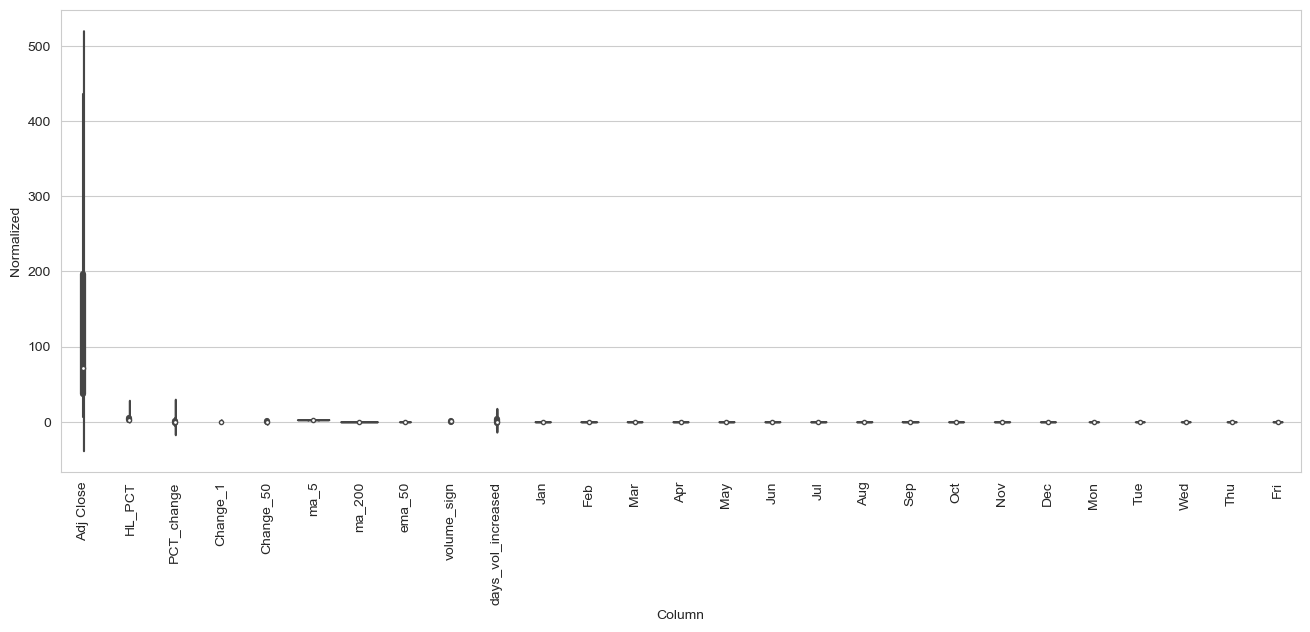

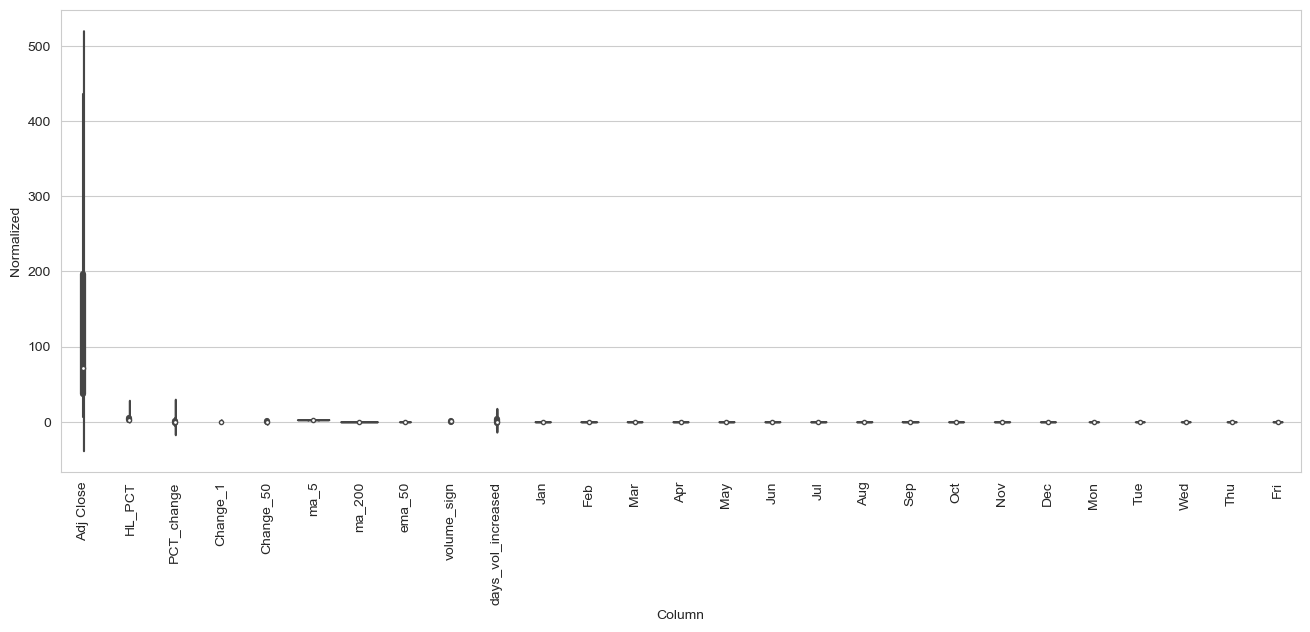

In [27]:
# Visualizing training data before scaling
df_train_melt = df_train.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(16, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_train_melt)
_ = ax.set_xticklabels(df_train.keys(), rotation=90)
plt.show()

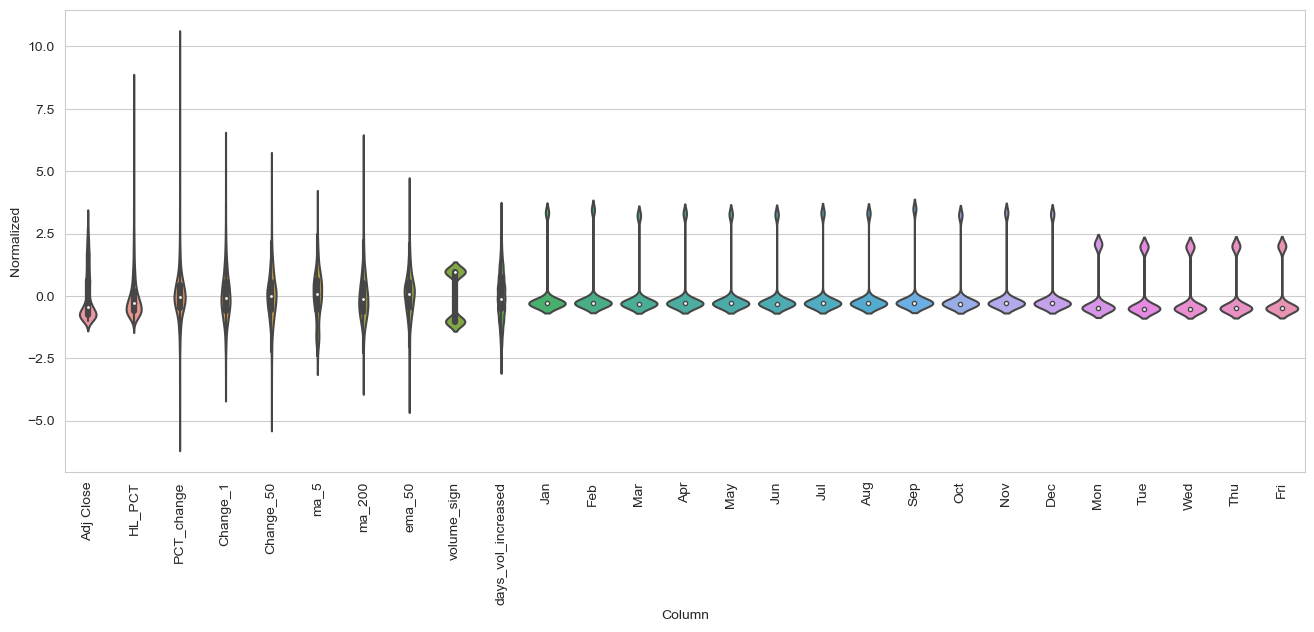

In [28]:
# Scaling
scaler = preprocessing.StandardScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), index=df_train.index)
df_train.columns = df_new.columns

# Note: We are not fitting the scalar again
df_val = pd.DataFrame(scaler.transform(df_val), index=df_val.index)
df_val.columns = df_new.columns

# Note: We are not fitting the scalar again
df_test = pd.DataFrame(scaler.transform(df_test), index=df_test.index)
df_test.columns = df_new.columns

# Visualizing training data after scaling
df_train_std_melt = df_train.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(16, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_train_std_melt)
_ = ax.set_xticklabels(df_train.keys(), rotation=90)
plt.show()

## Model Selection

### Base line model: Stock prices are the same as the year before (2020)

In [29]:
def baseline(df_train=df_train, df_val=df_val):
    """
    Initializes baseline model
    
    :params:
        df_train: pandas dataframe
            dataframe containing training data
            
        df_val: pandas dataframe
            dataframe containing validation data
        
    return:
        predictions:pandas dataframe
            dataframe containing data from the previous period.

    """
    predictions = df_train.iloc[-df_val['Adj Close'].shape[0]:, :]
    
    return predictions
    
    
# get predictions
predictions_baseline = baseline()
predictions_baseline.head()

# compute errors
compute_errors(np.array(df_val['Adj Close']), np.array(predictions_baseline['Adj Close']))

Mean squared error of a model is  72.79743909991826
Root mean squared error of a model is  8.53214153070132
Mean absolute percentage error of a model is  0.8397485773894728


#### Plot

In [30]:
predictions_baseline['Adj Close'].index = df_val.index

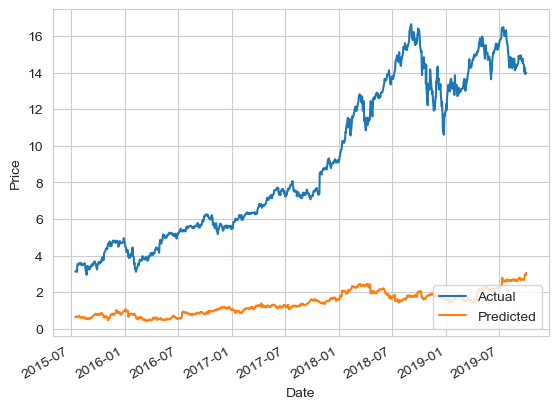

In [31]:
df_val['Adj Close'].plot(label='Actual')
predictions_baseline['Adj Close'].plot(label='Predicted')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Conclusion: The predictions for baseline model are quite poor with a mean absolute percentage error close to 40%. This is expected as the stockmarket has an upward trend and most successful companies see a growth over the year. Let's see how we can make it better.

### Keep it simple, keep it linear

In [32]:
# get the number steps to predict
OUT_STEPS = int(input())

7


#### N-day forecast

In [33]:
def train_test_split_nday_forecast(df_train=df_train, df_val=df_val):
    """
    Splits both the training and validation sets into X and Y
    
    :params:
        df_train: pandas dataframe
            dataframe containing training data
            
        df_val: pandas dataframe
            dataframe containing validation data
        
    :return:
        X_train:ndarray
            all training features
        X_val: ndarray
            all validation features
        y_train: ndarray
            training output variable
        y_val: ndarray
            validation output variable

    """
    
    df_temp_train = df_train.copy()
    df_temp_train['label'] = df_temp_train['Adj Close'].shift(-OUT_STEPS)
    df_temp_train = df_temp_train.dropna()

    df_temp_val = df_val.copy()
    df_temp_val['label'] = df_temp_val['Adj Close'].shift(-OUT_STEPS)
    df_temp_val =  df_temp_val.dropna()
    
    # Get X
    X_train = np.array(df_temp_train.drop(columns=['label']))
    X_val = np.array(df_temp_val.drop(columns=['label']))
    
    y_train = np.array(df_temp_train['label'])
    y_val = np.array(df_temp_val['label'])

    return X_train, X_val, y_train, y_val

##### Linear Regression

In [34]:
def linear_reg_n_day(df_train=df_train, df_val=df_val):
    """
    Initializes and fits Linear regression classfier   
    
    :params:
        df_train: pandas dataframe
            dataframe containing training data
            
        df_val: pandas dataframe
            dataframe containing validation data
        
    :return:
        predictions: ndarray
            predicted values
            
    """
    # Get train test data
    X_train, X_val, y_train, y_val = train_test_split_nday_forecast(df_train, df_val)
    
    # Create a classifier
    clfreg = LinearRegression()
    clfreg.fit(X_train, y_train)

    predictions = clfreg.predict(X_val)

    print(clfreg.score(X_val, y_val))
    
    compute_errors(y_val, predictions)
    
    return predictions

In [35]:
predictions = linear_reg_n_day()

0.9851260463226188
Mean squared error of a model is  0.26770598033852017
Root mean squared error of a model is  0.517403112030185
Mean absolute percentage error of a model is  0.040027179880186434


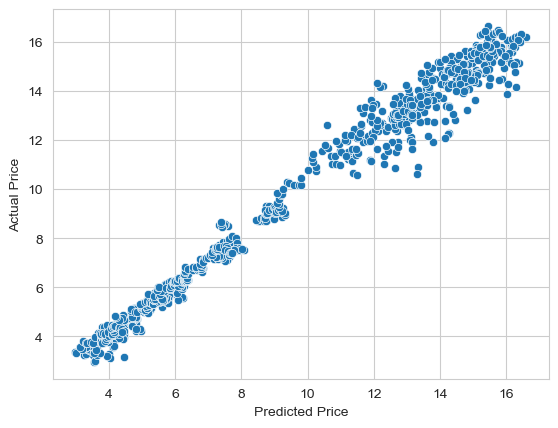

In [36]:
_, _, _, y_val = train_test_split_nday_forecast()
sns.scatterplot(x=predictions, y=y_val)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.show()

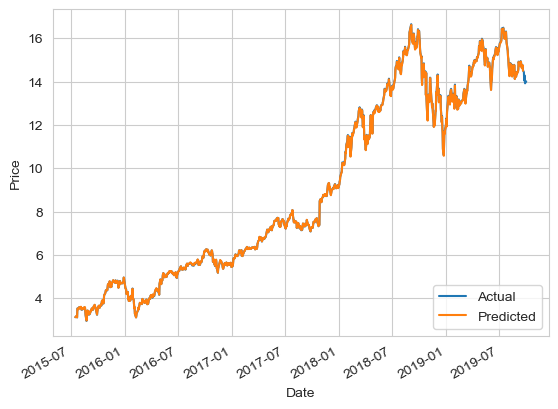

In [37]:
predictions_lin_reg = pd.DataFrame(data=predictions, columns=['Predicted'], index=df_val.index[:-OUT_STEPS])

df_val['Adj Close'].plot(label='Actual')
predictions_lin_reg['Predicted'].plot(label='Predicted')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

##### Polynomial regression (n^2) 

In [38]:
def quadratic_reg_n_day(df_train=df_train, df_val=df_val):
    """
    Initializes and fits Polynimoal regression classfier 
    
    :params:
        df_train: pandas dataframe
            dataframe containing training data
            
        df_val: pandas dataframe
            dataframe containing validation data
        
    :return:
        predictions: ndarray
            predicted values
    """
    
    # Get train test data
    X_train, X_val, y_train, y_val = train_test_split_nday_forecast(df_train, df_val)
    
    clfpoly = make_pipeline(PolynomialFeatures(2), Ridge())
    clfpoly.fit(X_train, y_train)
    
    predictions = clfpoly.predict(X_val)

    print(clfpoly.score(X_val, y_val))
    
    compute_errors(y_val, predictions)
    
    return predictions

0.897240657847219
Mean squared error of a model is  1.849494157816631
Root mean squared error of a model is  1.3599610868758822
Mean absolute percentage error of a model is  0.09616154565747377


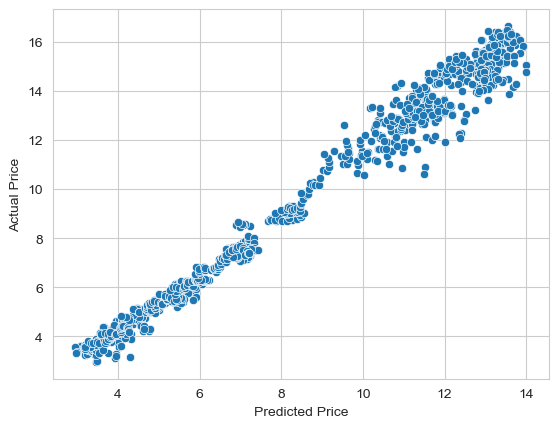

In [39]:
predictions_quad = quadratic_reg_n_day()

_, _, _, y_val = train_test_split_nday_forecast()

sns.scatterplot(x=predictions_quad, y=y_val)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.show()

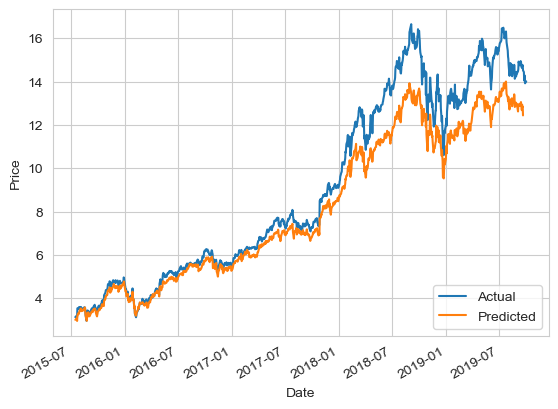

In [40]:
predictions_quad_reg = pd.DataFrame(data=predictions_quad, columns=['Predicted'], index=df_val.index[:-OUT_STEPS])

df_val['Adj Close'].plot(label='Actual')
predictions_quad_reg['Predicted'].plot(label='Predicted')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### k-Nearest Neighbors

In [41]:
def get_k_knn(X_train, X_val, y_train, y_val):
    """ 
    Returns the optimal number of nearest neighbors 
    
    :params:
        X_train: ndarray
            all training features
        X_val: ndarray
            all validation features
        y_train: ndarray
            training output variable
        y_val: ndarray
            validation output variable
        
    :return:
        n_neighbors: int
            optimal number of nearest neighbors
    """
    # genereate number of NN from 1 to 100
    k = [i for i in range(1,100)]
    mape = []
    
    # fit classifier 100 times
    for i in k:
        clfknn = KNeighborsRegressor(n_neighbors=i)
        clfknn.fit(X_train, y_train)
        predictions_knn = clfknn.predict(X_val)

        mape.append(mean_absolute_percentage_error(y_val, predictions_knn))

    # choose the optimal number of NN
    n_neighbors = mape.index(min(mape)) + 1
    
    return n_neighbors

In [42]:
def knn_n_days():
    """
    Initializes and fits k-Nearest Neighbors Classifier
    
    :params:
        None
        
    :return:
        predictions: ndarray
            predicted values
    
    """
    # get the data
    X_train, X_val, y_train, y_val = train_test_split_nday_forecast()
    
    n_neighbors = get_k_knn(X_train, X_val, y_train, y_val)
    
    # KNN Regression
    clfknn = KNeighborsRegressor(n_neighbors=n_neighbors,)
    clfknn.fit(X_train, y_train)

    # prediction
    predictions_knn = clfknn.predict(X_val)
    
    print('R2 is', clfknn.score(X_val, y_val))
    compute_errors(y_val, predictions_knn)
    
    return predictions_knn

R2 is -2.5982466710484804
Mean squared error of a model is  64.76234721893069
Root mean squared error of a model is  8.047505651997437
Mean absolute percentage error of a model is  0.7035267841961428


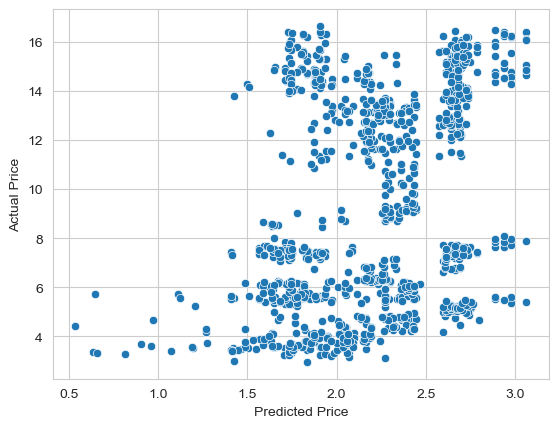

In [43]:
predictions_knn = knn_n_days()
    
sns.scatterplot(x=predictions_knn, y=y_val)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.show()

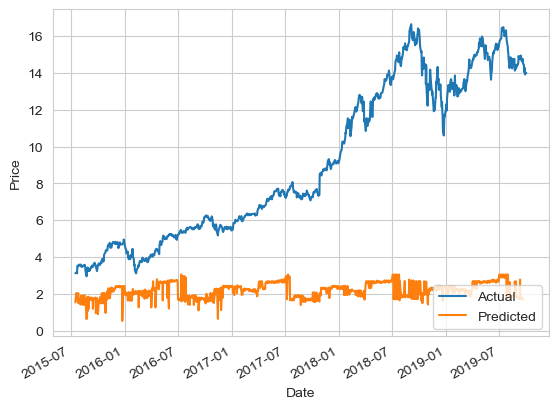

In [44]:
predictions_knn_df = pd.DataFrame(data=predictions_knn, columns=['Predicted'], index=df_val.index[:-OUT_STEPS])

df_val['Adj Close'].plot(label='Actual')
predictions_knn_df['Predicted'].plot(label='Predicted')
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

As we can see, metrics for KNN are much worse then those of a quadratic function. KNN failed to predict an upward trend.

---
### TensorFlow

*Source: https://www.tensorflow.org/tutorials/structured_data/time_series*

#### Data windowing 

![title](https://www.tensorflow.org/tutorials/structured_data/images/raw_window_24h.png)

In [45]:
class WindowGenerator():
    """
    A class to represent a window object.

    :attr:
        input_width: int
            history size
        label_width: int
            history size
        shift: int
            prediction of 'shift' days into the future
        X_train: ndarray
            all training features
        X_val: ndarray
            all validation features
        y_train: ndarray
            training output variable
        y_val: ndarray
            validation output variable

    methods:
        __repr__():
            Returns a string representing window object

    """
    def __init__(self, input_width, label_width, shift,
                 train_df=df_train, val_df=df_val, test_df=df_test,
                 label_columns=None):
        """
        Constructs all the necessary attributes for the Window object.

        :params:
            name : str
                first name of the person
            surname : str
                family name of the person
            age : int
                age of the person
                
        :returns:
            None
            
        """
        
        # Store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Work out the label column indices
        self.label_columns = label_columns
        
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
            
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        # Work out the window params
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        """
        Returns a string representing window object
        """
        
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])

#### Split

In [46]:
def split_window(self, features):
    """
    Given a list of consecutive inputs, convert them to a window of inputs and a window of labels.

    :params:
        features: tf tensor
            window object
            
    :return:
        inputs: tf tensor
            tensor of inputs
        labels: tf tensor
            tensor of labels
    """

    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    
    if self.label_columns is not None:
        labels = tf.stack([
            labels[:, :, self.column_indices[name]] for name in self.label_columns
        ], axis=-1)
    
    # preserve the shape of the input
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels
        

In [47]:
# add split_window method as a method on WindowGenerator class
WindowGenerator.split_window = split_window

#### Create tf.data.Datasets

In [48]:
def make_dataset(self, data):
    """
    Takes a time series DataFrame and converts it to a tf.data.Dataset of (input_window, label_window) pairs 
    using the preprocessing.timeseries_dataset_from_array function
    
    :params:
        data: DataFrame
            time series data
                    
    :return:
        ds: tf.data.Dataset
            time series data 
    
    """
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )
    
    ds = ds.map(self.split_window)
    
    return ds

# add make_dataset method to a WindowGenerator object
WindowGenerator.make_dataset = make_dataset

In [49]:
# Add properties for accessing them as tf.data.Datasets using the make_dataset method defined earlier
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)
        
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test

### Prediction Models

#### Baseline Model
Repeat the last input time step for the required number of output time steps

In [50]:
multi_window = WindowGenerator(
    input_width=100,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    label_columns=['Adj Close']
)

multi_window

Total window size: 107
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Label indices: [100 101 102 103 104 105 106]
Label column name(s): ['Adj Close']

In [51]:
class MultiStepLastBaseline(tf.keras.Model):
    """
    A class to represent a simple multi step baseline model.
            
    methods:
        call(inputs):
            Returns the last input time step for the required number of output time steps.
    """
    def call(self, inputs):
        """
        Returns the last input time step for the required number of output time steps.
        
        :params: tf tensor
        inputs: input to the model
        
        :return: tf tensor
            The last input time step for the required number of output time steps.
            
        """
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])


last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                     metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)

30/30 [==============================] - 0s 923us/step - loss: 107.3761 - mean_absolute_error: 9.3420


#### Single-shot models: Linear
Single-shot model makes the entire sequence prediction in a single step.

In [52]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=patience,
                                                      mode='min')
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                 optimizer=tf.optimizers.Adam(),
                 metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                       validation_data=multi_window.val,
                       callbacks=[early_stopping])
    
    return history

In [53]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]), 
    tf.keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)

30/30 [==============================] - 0s 808us/step - loss: 2.4201 - mean_absolute_error: 1.3531


In [54]:
print('Linear Model:', multi_val_performance['Linear'])
print('Baseline Last: ', multi_val_performance['Last'])

Linear Model: [2.4200692176818848, 1.3530755043029785]
Baseline Last:  [107.37614440917969, 9.3419828414917]


As we can see, Linear model does better than either baseline, but it is not great. We can try adding more Dense layers but it will still be bases on a single input time step. 

#### Single-shot models: Dense

In [55]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

30/30 [==============================] - 0s 963us/step - loss: 1.4456 - mean_absolute_error: 1.0106


In [56]:
print('Linear Model:', multi_val_performance['Linear'])
print('Dense Model:', multi_val_performance['Dense'])

Linear Model: [2.4200692176818848, 1.3530755043029785]
Dense Model: [1.445631504058838, 1.0106236934661865]


We've got the improved performance but the result is not satisfying. We can try using CNN that is based on a fixed-width history. This should lead to a better performance since CNN can see how things are changing over time.

#### Single-shot model: CNN

In [57]:
%%time

multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -3:, :]),
    tf.keras.layers.Conv1D(32, activation='relu', kernel_size=(3)),
    tf.keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)

30/30 [==============================] - 0s 849us/step - loss: 0.8268 - mean_absolute_error: 0.7473
CPU times: user 19.7 s, sys: 7.04 s, total: 26.7 s
Wall time: 5.51 s


In [58]:
print('Dense Model:', multi_val_performance['Dense'])
print('CNN Model:', multi_val_performance['Conv'])

Dense Model: [1.445631504058838, 1.0106236934661865]
CNN Model: [0.8267564177513123, 0.7473396062850952]


CNN did perform better than the Dense model. Let's see if we can improve the prediction by using RNN.

#### Single-shot model: RNN

In [59]:
%%time

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

30/30 [==============================] - 0s 5ms/step - loss: 66.2204 - mean_absolute_error: 7.0128
CPU times: user 1min 34s, sys: 22.1 s, total: 1min 56s
Wall time: 43.6 s


In [60]:
print('CNN Model:', multi_val_performance['Conv'])
print('LSTM Model:', multi_val_performance['LSTM'])

CNN Model: [0.8267564177513123, 0.7473396062850952]
LSTM Model: [66.22038269042969, 7.012828350067139]


#### Autoregressive: RNN

In [61]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
        
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [62]:
def warmup(self, inputs):
    x, *state = self.lstm_rnn(inputs)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [63]:
def call(self, inputs, training=None):
    predictions = []
    
    # Initialize the LSTM state.
    prediction, state = self.warmup(inputs)
    predictions.append(prediction)
    
    for n in range(1, self.out_steps):
        x = prediction
        x, state= self.lstm_cell(x, states=state, training=training)
        
        prediction = self.dense(x)
        predictions.append(prediction)
        
    predictions = tf.stack(predictions)
    predictions = tf.transpose(predictions, [1, 0, 2])
    
    return predictions


FeedBack.call = call

In [64]:
%%time
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
# multi_window.plot(feedback_model)


30/30 [==============================] - 0s 6ms/step - loss: 64.4159 - mean_absolute_error: 6.9049
CPU times: user 1min 33s, sys: 21.4 s, total: 1min 55s
Wall time: 40.5 s


In [65]:
print('CNN Model:', multi_val_performance['Conv'])
print('RNN Model:', multi_val_performance['LSTM'])
print('AR RNN Model:', multi_val_performance['AR LSTM'])

CNN Model: [0.8267564177513123, 0.7473396062850952]
RNN Model: [66.22038269042969, 7.012828350067139]
AR RNN Model: [64.41593933105469, 6.904943466186523]


#### Performance

In [66]:
multi_performance

{'Last': [647.3172607421875, 24.69113540649414],
 'Linear': [16.162683486938477, 3.8923916816711426],
 'Dense': [10.920982360839844, 3.154778003692627],
 'Conv': [5.8575568199157715, 2.2265944480895996],
 'LSTM': [552.7506713867188, 23.18517303466797],
 'AR LSTM': [552.55322265625, 23.166610717773438]}

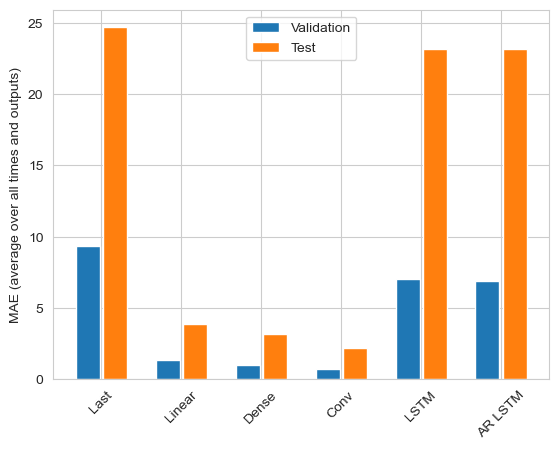

In [67]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = feedback_model.metrics_names.index(metric_name)
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

plt.show()

***Conclusion***: It seems like there is not a big difference between the last 5 models.
I think that LSTM should be more robust to new data samples, therefore I will use this model to make the prediction. 

### Re-train CNN Model on all data

In [68]:
# Save the model
multi_conv_model.save('conv_model')

INFO:tensorflow:Assets written to: conv_model/assets


In [69]:
# Make predictions and rescale them
predictions = multi_conv_model.predict(multi_window.test)
forecast = scaler.inverse_transform(predictions)
forecast.shape

(424, 7, 27)

In [72]:
# check the 7 day forecast value
forecast[-1:, :, 0]

array([[3038.8936, 3022.6536, 3008.3887, 3009.5183, 3027.199 , 3029.7615,
        3038.7024]], dtype=float32)

In [73]:
# compare with true values
df[-7:]['Adj Close']

Date
2021-10-28    3446.570068
2021-10-29    3372.429932
2021-11-01    3318.110107
2021-11-02    3312.750000
2021-11-03    3384.000000
2021-11-04    3477.000000
2021-11-05    3518.989990
Name: Adj Close, dtype: float64